## Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import KFold

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json
import umap

# ingnore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Load Data

In [2]:
# Load json file
def load_json(file_path):
    return pd.read_json(file_path)

# Load data
data = load_json('data/train.json')

# Load JSON data
cuisine_df = pd.json_normalize(data.to_dict(orient='records'))

## Process Data

In [3]:
# Combine ingredients into a single string for each recipe
cuisine_df['ingredients_str'] = cuisine_df['ingredients'].apply(lambda x: ' '.join(x))

# Preprocess ingredients (tokenize and remove stop words)
stop_words = set(stopwords.words('english'))

def preprocess_ingredients(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

cuisine_df['ingredients_clean'] = cuisine_df['ingredients_str'].apply(preprocess_ingredients)

In [4]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_clean'])
y = cuisine_df['cuisine']

## Split Data

In [5]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# Kfold split
kfold = KFold(n_splits = 5,
              shuffle = True)

## Cross-Validation for Models

In [7]:
# Store the accuracy
acc = np.zeros((4, 5))

# Keeps track of the split
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## Creates training split on the training set
    X_train_train = X_train[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## Creates holdout data for testing
    X_holdout = X_train[test_index,:]
    y_holdout = y_train.iloc[test_index]
    
    # Model 1 - LinearSVC
    model_1 = LinearSVC(dual = 'auto')
    model_1.fit(X_train_train, y_train_train)
    y_holdout_predict_1 = model_1.predict(X_holdout)
    
    #Store Accuracy
    acc[0,i] = accuracy_score(y_holdout, y_holdout_predict_1)
    
    # Model 2 - Logistic Regression
    model_2 = LogisticRegression(penalty=None, max_iter= 100000)
    model_2.fit(X_train_train, y_train_train)
    y_holdout_predict_2 = model_2.predict(X_holdout)
    
    # Store Accuracy
    acc[1,i] = accuracy_score(y_holdout, y_holdout_predict_2)
    
    # Model 3 - KNN
    model_3 = KNeighborsClassifier()
    model_3.fit(X_train_train, y_train_train)
    y_holdout_predict_3 = model_3.predict(X_holdout)
    
    # Store Accuracy
    acc[2,i] = accuracy_score(y_holdout, y_holdout_predict_3)
    
    # Model 4 - Random Forest
    model_4 = RandomForestClassifier()
    model_4.fit(X_train_train, y_train_train)
    y_holdout_predict_4 = model_4.predict(X_holdout)
    
    # Store Accuracy
    acc[3,i] = accuracy_score(y_holdout, y_holdout_predict_4)
    
    # Moves onto the next split
    i = i + 1

## Plots Performance

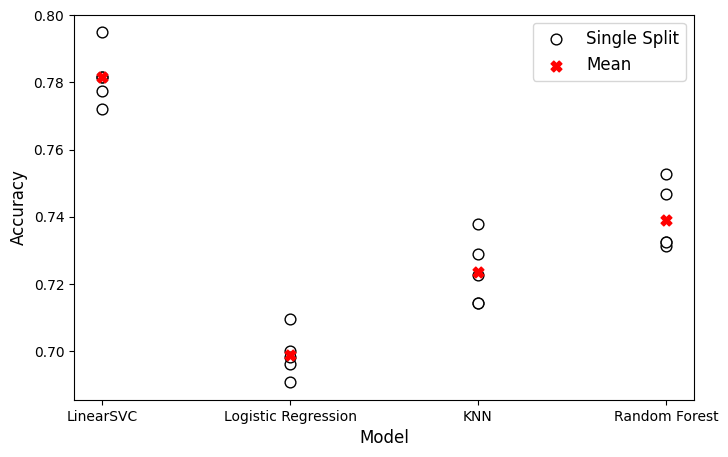

In [8]:
## Figure to compare the performances
plt.figure(figsize=(8,5))

# Plots LinearSVC
plt.scatter(np.zeros(5), 
            acc[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")

# Plots Logistic Regression
plt.scatter(np.ones(5), 
            acc[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots KNN
plt.scatter(2*np.ones(5), 
            acc[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Random Forest
plt.scatter(3*np.ones(5), 
            acc[3,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Average
plt.scatter([0,1,2,3], 
            np.mean(acc, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# Creates Legend
plt.legend(fontsize=12)

# Labels Ticks
plt.xticks([0,1,2,3],["LinearSVC", "Logistic Regression", "KNN", "Random Forest"], fontsize=10)
plt.yticks(fontsize=10)

#Labels Graphs
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Plots Graph
plt.show()